# 1. Pre Configuration Dataset

In [ ]:
# load libraries 
import os, math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from random import randint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change directory
os.chdir("/content/drive/MyDrive/dataset")

In [ ]:
# extract zip files
# !unzip "/content/drive/MyDrive/Dataset/filtered_dataset.zip"

In [ ]:
# check total file on unzip folder
ListClass, ListLength = [], []
parent = "filtered_dataset"
for params in tqdm(os.listdir(parent)):
  child = os.path.join(parent, params)
  if os.path.isdir(child):
    for _cls in os.listdir(child):
      if os.path.isdir(os.path.join(child, _cls)):
        ListClass.append(_cls)
        ListLength.append(os.listdir(os.path.join(child, _cls)).__len__())

100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


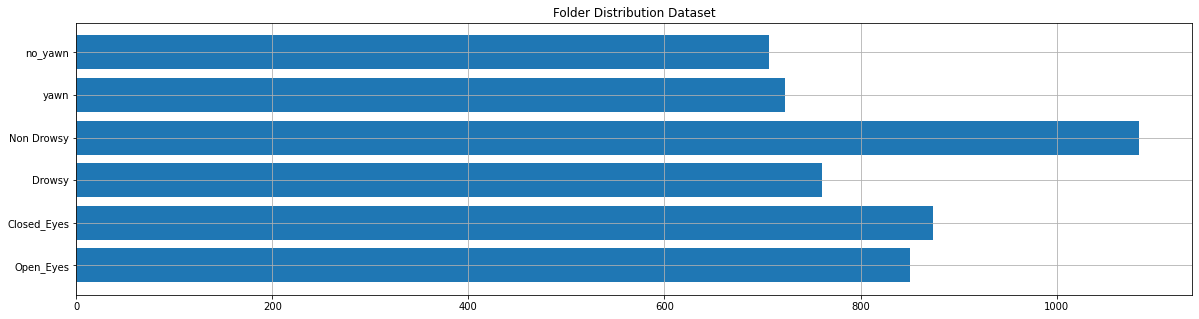

In [ ]:
plt.figure(figsize = (20, 5))
plt.barh(ListClass, ListLength)
plt.grid(True)
plt.title("Folder Distribution Dataset");

In [ ]:
# define additional function to suit tensorflow model with sklearn plot_confusion_matrix
class Metrics:
  """
  how to used:
    
    # inialize Metrics class as metrics variable.
    metrics = Metrics(model = <define_ur_trained_model_here>, data_generator = <define_ur_datagenerator_here>)

    # generate classification report 
    metrics.generate_class_report() 

    # generate plot confusion matrix
    metrics.generate_confusion_matrix()

  """
  def __init__(self, n_batch = 16, model = None, data_generator = None):
    """
    args:
      - n_batch: int = 16 (default), to define total batch of data inside ImageDataGenerator is equal to unpacked data_generator object.
      - model: tf.keras.Sequential() = None, to apply trained model for our prediction label variable based on trained model.
      - data_generator: tf.keras.preprocessing.image.ImageDataGenerator() = None, to re-define our data generated based on directory into batches array.
    """
    self.batch_size = n_batch
    self.model = model
    self.data = data_generator
    self._n_ran = randint(5, self.batch_size)
    self._n_sam = [randint(0, 1) for i in range(self._n_ran)]
    self._n_gen = math.ceil(self.data.filenames.__len__() / (1.0 * self.batch_size))
    self.cond = True 

    self.true = None 
    self.pred = None

  def predict_categorical(self):
    return self.model.predict(self.data)

  def _iter_label_generator(self):
    return np.array([self.data[idx][1] for idx in range(0, int(self._n_gen))])
  
  def _convert_categorical_to_sparse(self):
    pred = self.predict_categorical().argmax(axis = 1)
    true = pred.copy() if self.cond else self._iter_label_generator()
    true[:self._n_ran] = self._n_sam 
    return true, pred

  def generate_class_report(self):
    true, pred = self._convert_categorical_to_sparse()

    self.true = true
    self.pred = pred

    print(classification_report(true, pred))

  def _confusion_matrix(self):
    return confusion_matrix(self.true, self.pred).tolist() 

  def generate_confusion_matrix(self):
    arr = self._confusion_matrix()
    data = pd.DataFrame(arr, range(2), range(2))
    sns.heatmap(data, annot = True, cmap = "viridis")

# 2. Classification Task

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

## 2.1. Yawn Detection (Yes / No)

In [ ]:
# change directory
os.chdir("filtered_dataset")

In [ ]:
# check list directory
os.listdir("mouth")

['yawn', 'no_yawn']

In [ ]:
# define variable
DIRECTORY  = "mouth"
BATCH_SIZE = 16
EPOCHS     = 100

In [ ]:
# define image data generator 
image_generator = ImageDataGenerator(
    validation_split = 0.1,
    rescale = 1 / 255,
)

In [ ]:
# apply image generator
train_set = image_generator.flow_from_directory( 
    DIRECTORY,
    class_mode = "categorical", batch_size = BATCH_SIZE, 
    subset = "training", target_size = (224, 224), 
    color_mode = "rgb"
)
test_set = image_generator.flow_from_directory( 
    DIRECTORY, 
    class_mode = "categorical", batch_size = BATCH_SIZE,
    subset = "validation", target_size = (224, 224), 
    color_mode = "rgb" 
)

Found 1288 images belonging to 2 classes.
Found 142 images belonging to 2 classes.


In [ ]:
# create CNN architecture for binary classification

def build_model_mouth():

  model = Sequential()

  model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3), kernel_initializer='he_uniform'))
  model.add(MaxPool2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPool2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPool2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPool2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPool2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Flatten())

  model.add(Dropout(0.3))
  model.add(Dense(128, kernel_initializer = "he_uniform", activation = "relu"))
  model.add(Dense(2, activation = "softmax"))

  model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['acc'])

  return model 

In [ ]:
# inherit model CNN pre-defined above
model_mouth = build_model_mouth()

In [ ]:
# overview model architecture 
print(model_mouth.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                        

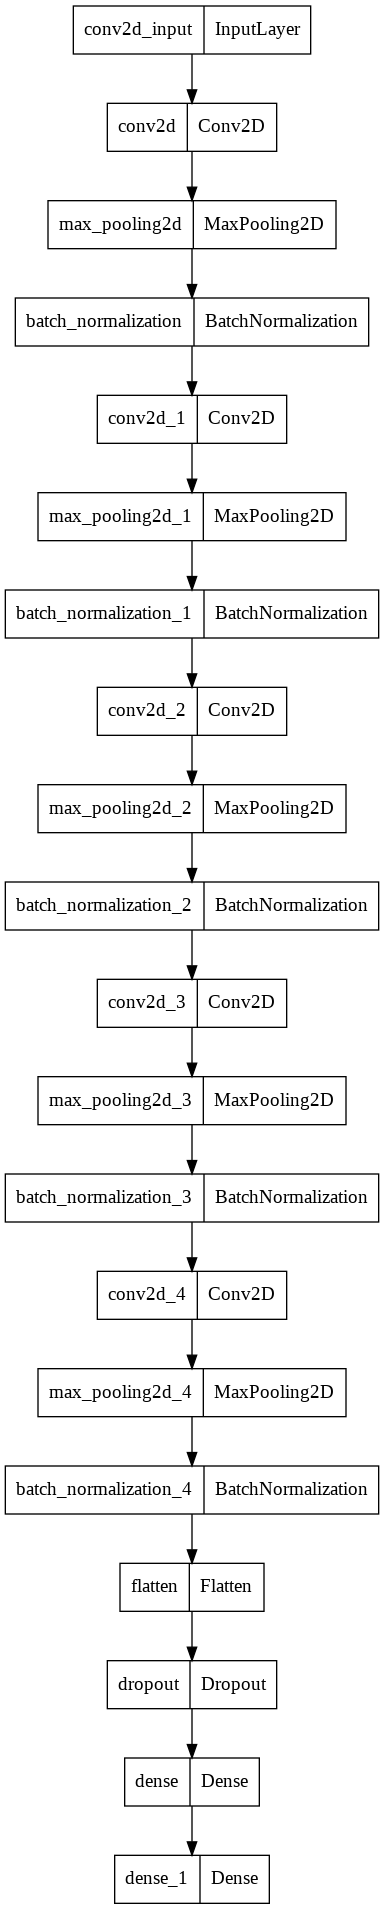

In [ ]:
# visualize model architecture
plot_model(model_mouth)

In [ ]:
# define callbacks to stop iteration
class CustomCallbacks(Callback):
  def __init__(self, threshold = 0.9):
    super(CustomCallbacks, self).__init__() 
    self.threshold = threshold 
  def on_epoch_end(self, epoch, logs = None, monitor = "val_acc"):
    val_acc = logs[monitor]
    if val_acc >= self.threshold: 
      self.model.stop_training = True

In [ ]:
# training model
history_mouth = model_mouth.fit(
    train_set, 
    epochs = EPOCHS, 
    validation_data = test_set, 
    verbose = 1,
    callbacks = [CustomCallbacks()]
)

Epoch 1/100
81/81 [==============================] - 555s 7s/step - loss: 0.6918 - acc: 0.6925 - val_loss: 1.3662 - val_acc: 0.4930
Epoch 2/100
81/81 [==============================] - 10s 124ms/step - loss: 0.4024 - acc: 0.8144 - val_loss: 0.8141 - val_acc: 0.5211
Epoch 3/100
81/81 [==============================] - 10s 125ms/step - loss: 0.2079 - acc: 0.9154 - val_loss: 1.5955 - val_acc: 0.5000
Epoch 4/100
81/81 [==============================] - 10s 124ms/step - loss: 0.1339 - acc: 0.9573 - val_loss: 1.8285 - val_acc: 0.5423
Epoch 5/100
81/81 [==============================] - 10s 126ms/step - loss: 0.0625 - acc: 0.9783 - val_loss: 0.8838 - val_acc: 0.6972
Epoch 6/100
81/81 [==============================] - 10s 125ms/step - loss: 0.0296 - acc: 0.9907 - val_loss: 1.0229 - val_acc: 0.7324
Epoch 7/100
81/81 [==============================] - 10s 126ms/step - loss: 0.0259 - acc: 0.9946 - val_loss: 1.6163 - val_acc: 0.7394
Epoch 8/100
81/81 [==============================] - 10s 125ms/s

In [ ]:
# wrap metrics training into dataframe
metrics_mouth = pd.DataFrame(history_mouth.history)

result_style = metrics_mouth.style.highlight_max(axis=0, props='background-color:#90B77D;', subset=['acc','val_acc']).highlight_min(axis=0, props='background-color:#EE6983;', subset=['loss','val_loss'])
result_style

,loss,acc,val_loss,val_acc
0,0.691767,0.692547,1.366188,0.492958
1,0.402443,0.814441,0.814115,0.521127
2,0.207871,0.915373,1.595518,0.500000
3,0.133892,0.957298,1.828456,0.542253
4,0.062480,0.978261,0.883765,0.697183
5,0.029578,0.990683,1.022918,0.732394
6,0.025916,0.994565,1.616331,0.739437
7,0.014848,0.993789,2.217034,0.570423
8,0.014292,0.994565,1.279109,0.711268
9,0.016537,0.993789,0.921825,0.732394


In [ ]:
# get statistic information

idx = list(metrics_mouth.describe().index.get_level_values(0))
_ls = lambda x : (idx[1:], x)

metrics_mouth.describe().style.highlight_max(axis=0, props='background-color:#90B77D;', subset = _ls(['acc','val_acc'])).highlight_min(axis=0, props='background-color:#EE6983;', subset = _ls(['loss','val_loss']))

,loss,acc,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000
mean,0.028212,0.989984,1.363645,0.760986
std,0.090265,0.037533,0.888571,0.068269
min,0.000005,0.692547,0.664622,0.492958
25%,0.000029,0.996700,1.076694,0.760563
50%,0.000218,1.000000,1.216919,0.774648
75%,0.010245,1.000000,1.418812,0.783451
max,0.691767,1.000000,9.261936,0.880282


In [ ]:
# save metrics into xlsx
result_style.to_excel('metrics_mouth.xlsx', engine='openpyxl')

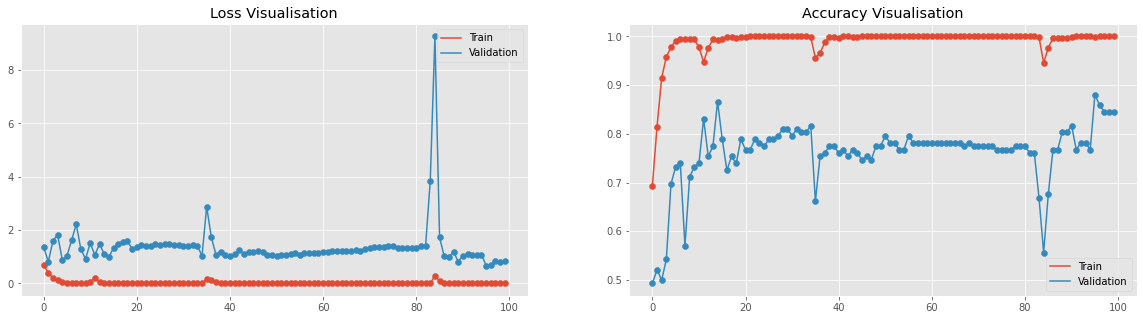

In [ ]:
# visualize training model evaluation
plt.style.use("ggplot")
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

index = list(range(len(history_mouth.history['loss'])))

ax[0].plot(history_mouth.history['loss'], label = f"Train")
ax[0].plot(history_mouth.history['val_loss'], label = f"Validation")
ax[0].scatter(index, history_mouth.history['loss'])
ax[0].scatter(index, history_mouth.history['val_loss'])
ax[0].legend()
ax[0].set_title("Loss Visualisation")

ax[1].plot(history_mouth.history['acc'], label = f"Train")
ax[1].plot(history_mouth.history['val_acc'], label = f"Validation")
ax[1].scatter(index, history_mouth.history['acc'])
ax[1].scatter(index, history_mouth.history['val_acc'])
ax[1].legend()
ax[1].set_title("Accuracy Visualisation")

plt.show()

In [ ]:
# save model
model_mouth.save("model_cnn_mouth.h5")

In [ ]:
# model evaluation based on evaluate function
_loss, _acc = model_mouth.evaluate(test_set)
print("Validation Accuracy >>>", _acc)
print("Validation Loss     >>>", _loss)

9/9 [==============================] - 1s 105ms/step - loss: 0.8484 - acc: 0.8451
Validation Accuracy >>> 0.8450704216957092
Validation Loss     >>> 0.8484307527542114


In [ ]:
# model evaluation based on classification_report and confusion_matrix scoring.
metrics_mouth = Metrics(model = model_mouth, data_generator = test_set)

In [ ]:
metrics_mouth.generate_class_report()

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        65
           1       0.95      0.99      0.97        77

    accuracy                           0.96       142
   macro avg       0.97      0.96      0.96       142
weighted avg       0.97      0.96      0.96       142



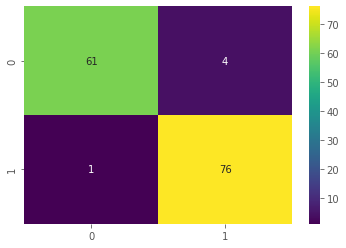

In [ ]:
metrics_mouth.generate_confusion_matrix()

## 2.2. Eyes Detection (Open / Closed)

In [ ]:
# change directory
os.chdir("filtered_dataset")

FileNotFoundError: ignored

In [ ]:
# check list directory
os.listdir("eye")

['Open_Eyes', 'Closed_Eyes']

In [ ]:
# define variable
DIRECTORY  = "eye"
BATCH_SIZE = 32
EPOCHS     = 100

In [ ]:
# define image data generator 
image_generator = ImageDataGenerator(
    validation_split = 0.1,
    rescale = 1 / 255,
)

In [ ]:
# apply image generator
train_set = image_generator.flow_from_directory( 
    DIRECTORY,
    class_mode = "categorical", batch_size = BATCH_SIZE, 
    subset = "training", target_size = (224, 224), 
    color_mode = "grayscale"
)
test_set = image_generator.flow_from_directory( 
    DIRECTORY, 
    class_mode = "categorical", batch_size = BATCH_SIZE,
    subset = "validation", target_size = (224, 224), 
    color_mode = "grayscale" 
)

Found 1552 images belonging to 2 classes.
Found 172 images belonging to 2 classes.


In [ ]:
# create CNN architecture for binary classification

def build_model_eye():

  model = Sequential()

  model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,1), kernel_initializer='he_uniform'))
  model.add(MaxPool2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPool2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPool2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Flatten())

  model.add(Dropout(0.3))
  model.add(Dense(128, kernel_initializer = "he_uniform", activation = "relu"))
  model.add(Dense(2, activation = "softmax"))

  model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['acc'])

  return model 

In [ ]:
# inherit model CNN pre-defined above
model_eye = build_model_eye()

In [ ]:
# overview model architecture 
print(model_eye.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 16)      80        
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 112, 112, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                      

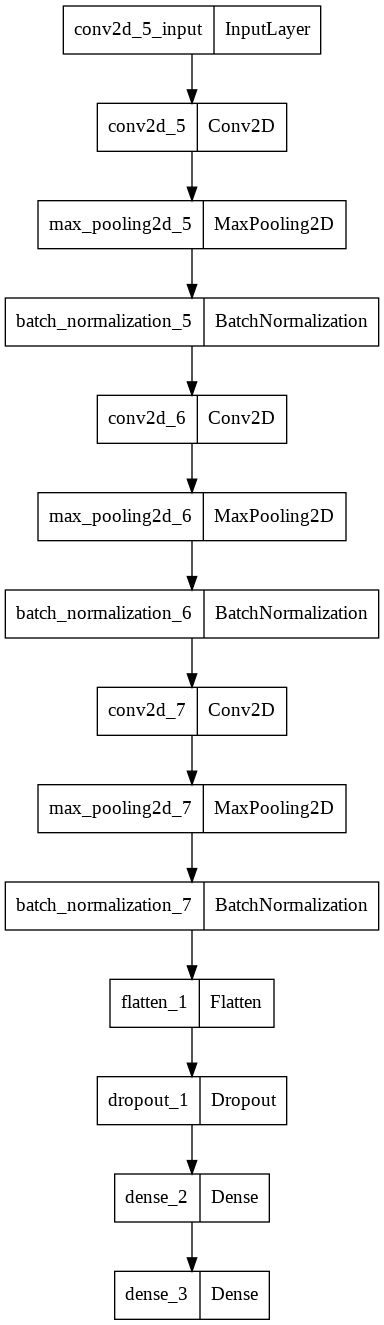

In [ ]:
# visualize model architecture
plot_model(model_eye)

In [ ]:
# define callbacks to stop iteration
class CustomCallbacks(Callback):
  def __init__(self, threshold = 0.9):
    super(CustomCallbacks, self).__init__() 
    self.threshold = threshold 
  def on_epoch_end(self, epoch, logs = None, monitor = "val_acc"):
    val_acc = logs[monitor]
    if val_acc >= self.threshold: 
      self.model.stop_training = True

In [ ]:
# training model
history_eye = model_eye.fit(
    train_set, 
    epochs = EPOCHS, 
    validation_data = test_set, 
    verbose = 1,
    callbacks = [CustomCallbacks()]
)

Epoch 1/100
49/49 [==============================] - 632s 13s/step - loss: 1.7834 - acc: 0.9227 - val_loss: 2.8261 - val_acc: 0.5058
Epoch 2/100
49/49 [==============================] - 3s 64ms/step - loss: 0.0464 - acc: 0.9878 - val_loss: 2.7947 - val_acc: 0.5058
Epoch 3/100
49/49 [==============================] - 3s 63ms/step - loss: 0.0189 - acc: 0.9955 - val_loss: 1.7671 - val_acc: 0.5058
Epoch 4/100
49/49 [==============================] - 3s 63ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 2.5756 - val_acc: 0.5058
Epoch 5/100
49/49 [==============================] - 3s 64ms/step - loss: 0.0063 - acc: 0.9974 - val_loss: 1.7319 - val_acc: 0.5058
Epoch 6/100
49/49 [==============================] - 3s 63ms/step - loss: 0.0021 - acc: 0.9994 - val_loss: 1.4177 - val_acc: 0.5058
Epoch 7/100
49/49 [==============================] - 3s 64ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.7231 - val_acc: 0.6977
Epoch 8/100
49/49 [==============================] - 3s 64ms/step - loss: 4

In [ ]:
# wrap metrics training into dataframe
metrics_eye = pd.DataFrame(history_eye.history)

result_style = metrics_eye.style.highlight_max(axis=0, props='background-color:#90B77D;', subset=['acc','val_acc']).highlight_min(axis=0, props='background-color:#EE6983;', subset=['loss','val_loss'])
result_style

,loss,acc,val_loss,val_acc
0,1.783383,0.922680,2.826095,0.505814
1,0.046406,0.987758,2.794713,0.505814
2,0.018861,0.995490,1.767140,0.505814
3,0.001286,1.000000,2.575634,0.505814
4,0.006292,0.997423,1.731883,0.505814
5,0.002062,0.999356,1.417651,0.505814
6,0.001505,1.000000,0.723101,0.697674
7,0.000477,1.000000,0.952633,0.616279
8,0.000304,1.000000,0.520710,0.872093
9,0.000206,1.000000,0.540565,0.860465


In [ ]:
# get statistic information

idx = list(metrics_eye.describe().index.get_level_values(0))
_ls = lambda x : (idx[1:], x)

metrics_eye.describe().style.highlight_max(axis=0, props='background-color:#90B77D;', subset = _ls(['acc','val_acc'])).highlight_min(axis=0, props='background-color:#EE6983;', subset = _ls(['loss','val_loss']))

,loss,acc,val_loss,val_acc
count,11.000000,11.000000,11.000000,11.000000
mean,0.169188,0.991155,1.476287,0.635307
std,0.535550,0.023011,0.934584,0.168947
min,0.000206,0.922680,0.389037,0.505814
25%,0.000390,0.996456,0.631833,0.505814
50%,0.001505,1.000000,1.417651,0.505814
75%,0.012576,1.000000,2.171387,0.779070
max,1.783383,1.000000,2.826095,0.906977


In [ ]:
# save metrics into xlsx
result_style.to_excel('metrics_eye.xlsx', engine='openpyxl')

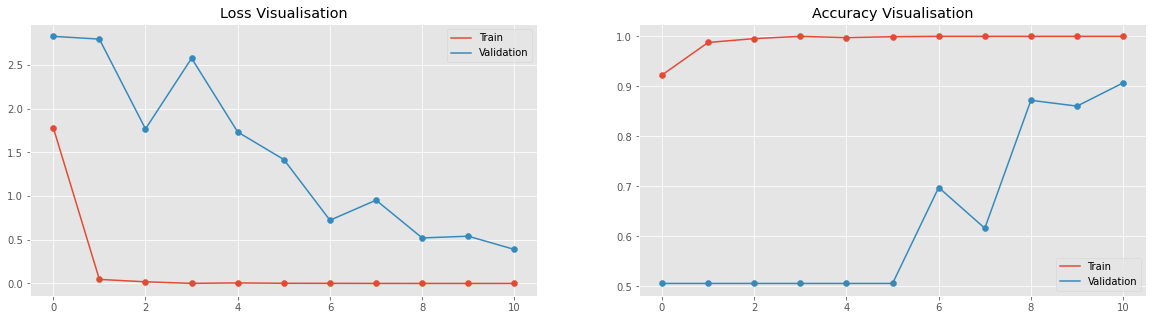

In [ ]:
# visualize training model evaluation
plt.style.use("ggplot")
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

index = list(range(len(history_eye.history['loss'])))

ax[0].plot(history_eye.history['loss'], label = f"Train")
ax[0].plot(history_eye.history['val_loss'], label = f"Validation")
ax[0].scatter(index, history_eye.history['loss'])
ax[0].scatter(index, history_eye.history['val_loss'])
ax[0].legend()
ax[0].set_title("Loss Visualisation")

ax[1].plot(history_eye.history['acc'], label = f"Train")
ax[1].plot(history_eye.history['val_acc'], label = f"Validation")
ax[1].scatter(index, history_eye.history['acc'])
ax[1].scatter(index, history_eye.history['val_acc'])
ax[1].legend()
ax[1].set_title("Accuracy Visualisation")

plt.show()

In [ ]:
# save model
model_eye.save("model_cnn_eye.h5")

In [ ]:
# model evaluation based on evaluate function
_loss, _acc = model_eye.evaluate(test_set)
print("Validation Accuracy >>>", _acc)
print("Validation Loss     >>>", _loss)

6/6 [==============================] - 0s 43ms/step - loss: 0.3890 - acc: 0.9070
Validation Accuracy >>> 0.9069767594337463
Validation Loss     >>> 0.38903671503067017


In [ ]:
# model evaluation based on classification_report and confusion_matrix scoring.
metrics_eye = Metrics(model = model_eye, data_generator = test_set)

In [ ]:
metrics_eye.generate_class_report()

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.96      0.98        72

    accuracy                           0.98       172
   macro avg       0.99      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172



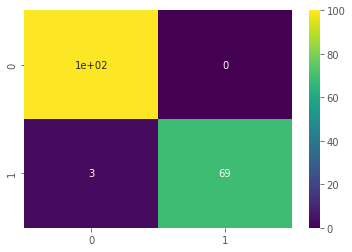

In [ ]:
metrics_eye.generate_confusion_matrix()

## 2.3. Head Detection (Fatigue / Not)

In [ ]:
# change directory
os.chdir("filtered_dataset")

FileNotFoundError: ignored

In [ ]:
# check list directory
os.listdir("head")

['preprocess.py', 'Drowsy', 'Non Drowsy']

In [ ]:
# !unzip "/content/drive/MyDrive/Dataset/filtered_dataset/head/head.zip"

In [ ]:
# define variable
DIRECTORY  = "head"
BATCH_SIZE = 16
EPOCHS     = 5

In [ ]:
# define image data generator 
image_generator = ImageDataGenerator(
    validation_split = 0.1,
    rescale = 1 / 255,
)

In [ ]:
# apply image generator
train_set = image_generator.flow_from_directory( 
    DIRECTORY,
    class_mode = "categorical", batch_size = BATCH_SIZE, 
    subset = "training", target_size = (224, 224), 
    color_mode = "rgb"
)
test_set = image_generator.flow_from_directory( 
    DIRECTORY, 
    class_mode = "categorical", batch_size = BATCH_SIZE,
    subset = "validation", target_size = (224, 224), 
    color_mode = "rgb" 
)

Found 1661 images belonging to 2 classes.
Found 184 images belonging to 2 classes.


In [ ]:
# create CNN architecture for binary classification

def build_model_head():

  model = Sequential()

  model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3), kernel_initializer='he_uniform'))
  model.add(MaxPool2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPool2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPool2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Flatten())

  model.add(Dropout(0.3))
  model.add(Dense(64, kernel_initializer = "he_uniform", activation = "relu"))
  model.add(Dense(2, activation = "softmax"))

  model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['acc'])

  return model 

In [ ]:
# inherit model CNN pre-defined above
model_head = build_model_head()

In [ ]:
# overview model architecture 
print(model_head.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 16)      208       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 112, 112, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                      

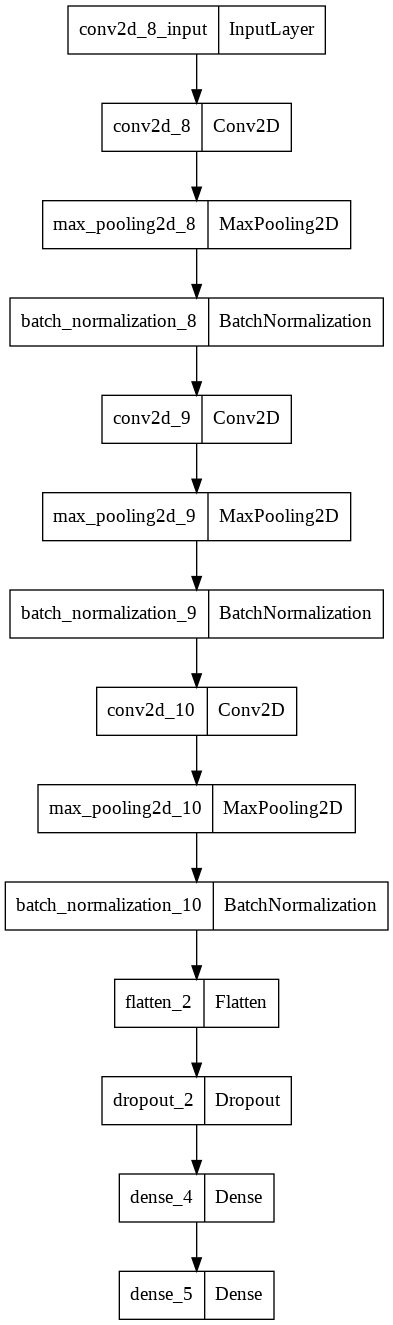

In [ ]:
# visualize model architecture
plot_model(model_head)

In [ ]:
# define callbacks to stop iteration
class CustomCallbacks(Callback):
  def __init__(self, threshold = 0.9):
    super(CustomCallbacks, self).__init__() 
    self.threshold = threshold 
  def on_epoch_end(self, epoch, logs = None, monitor = "val_acc"):
    val_acc = logs[monitor]
    if val_acc >= self.threshold: 
      self.model.stop_training = True

In [ ]:
# training model
history_head = model_head.fit(
    train_set, 
    epochs = EPOCHS, 
    validation_data = test_set, 
    verbose = 1,
    callbacks = [CustomCallbacks()]
)

Epoch 1/5
104/104 [==============================] - 490s 5s/step - loss: 0.2835 - acc: 0.9573 - val_loss: 1.7931 - val_acc: 0.5870
Epoch 2/5
104/104 [==============================] - 9s 85ms/step - loss: 0.0024 - acc: 0.9994 - val_loss: 0.9214 - val_acc: 0.7011
Epoch 3/5
104/104 [==============================] - 9s 85ms/step - loss: 0.0018 - acc: 0.9994 - val_loss: 1.1863 - val_acc: 0.6304
Epoch 4/5
104/104 [==============================] - 9s 85ms/step - loss: 0.0021 - acc: 0.9994 - val_loss: 2.2182 - val_acc: 0.7065
Epoch 5/5
104/104 [==============================] - 9s 85ms/step - loss: 8.4099e-05 - acc: 1.0000 - val_loss: 2.6044 - val_acc: 0.7120


In [ ]:
# wrap metrics training into dataframe
metrics_head = pd.DataFrame(history_head.history)

result_style = metrics_head.style.highlight_max(axis=0, props='background-color:#90B77D;', subset=['acc','val_acc']).highlight_min(axis=0, props='background-color:#EE6983;', subset=['loss','val_loss'])
result_style

,loss,acc,val_loss,val_acc
0,0.283550,0.957255,1.793143,0.586957
1,0.002377,0.999398,0.921432,0.701087
2,0.001765,0.999398,1.186254,0.630435
3,0.002081,0.999398,2.218197,0.706522
4,0.000084,1.000000,2.604431,0.711957


In [ ]:
# get statistic information

idx = list(metrics_head.describe().index.get_level_values(0))
_ls = lambda x : (idx[1:], x)

metrics_head.describe().style.highlight_max(axis=0, props='background-color:#90B77D;', subset = _ls(['acc','val_acc'])).highlight_min(axis=0, props='background-color:#EE6983;', subset = _ls(['loss','val_loss']))

,loss,acc,val_loss,val_acc
count,5.000000,5.000000,5.000000,5.000000
mean,0.057971,0.991090,1.744691,0.667391
std,0.126105,0.018916,0.699163,0.055875
min,0.000084,0.957255,0.921432,0.586957
25%,0.001765,0.999398,1.186254,0.630435
50%,0.002081,0.999398,1.793143,0.701087
75%,0.002377,0.999398,2.218197,0.706522
max,0.283550,1.000000,2.604431,0.711957


In [ ]:
# save metrics into xlsx
result_style.to_excel('metrics_head.xlsx', engine='openpyxl')

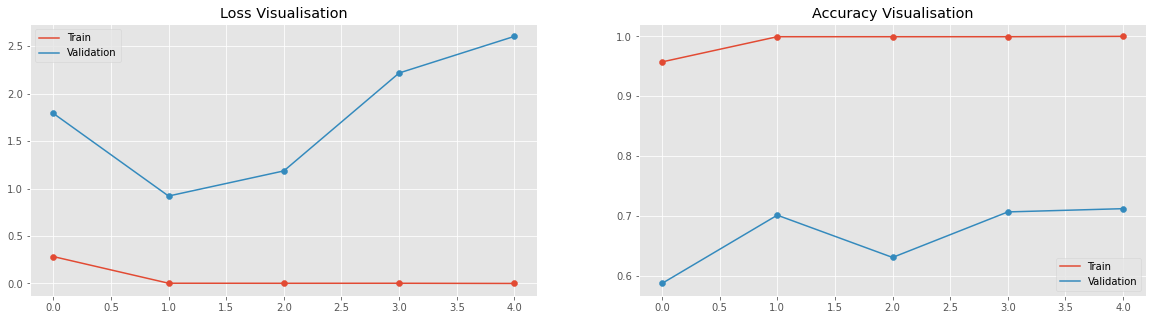

In [ ]:
# visualize training model evaluation
plt.style.use("ggplot")
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

index = list(range(len(history_head.history['loss'])))

ax[0].plot(history_head.history['loss'], label = f"Train")
ax[0].plot(history_head.history['val_loss'], label = f"Validation")
ax[0].scatter(index, history_head.history['loss'])
ax[0].scatter(index, history_head.history['val_loss'])
ax[0].legend()
ax[0].set_title("Loss Visualisation")

ax[1].plot(history_head.history['acc'], label = f"Train")
ax[1].plot(history_head.history['val_acc'], label = f"Validation")
ax[1].scatter(index, history_head.history['acc'])
ax[1].scatter(index, history_head.history['val_acc'])
ax[1].legend()
ax[1].set_title("Accuracy Visualisation")

plt.show()

In [ ]:
# save model
model_head.save("model_cnn_head.h5")

In [ ]:
# model evaluation based on classification_report and confusion_matrix scoring.
_loss, _acc = model_head.evaluate(test_set)
print("Validation Accuracy >>>", _acc)
print("Validation Loss     >>>", _loss)

12/12 [==============================] - 1s 73ms/step - loss: 2.6044 - acc: 0.7120
Validation Accuracy >>> 0.7119565010070801
Validation Loss     >>> 2.604430913925171


In [ ]:
# model evaluation based on classification_report and confusion_matrix scoring.
metrics_head = Metrics(model = model_head, data_generator = test_set)

In [ ]:
metrics_head.generate_class_report()

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       120
           1       1.00      0.92      0.96        64

    accuracy                           0.97       184
   macro avg       0.98      0.96      0.97       184
weighted avg       0.97      0.97      0.97       184



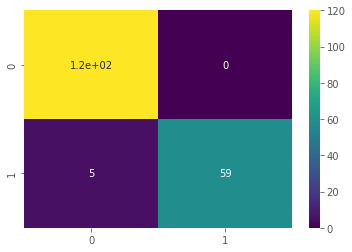

In [ ]:
metrics_head.generate_confusion_matrix()